# Librerías


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import requests

# Lectura de datos


In [3]:
repo_url = "https://github.com/CristianCazares/SeniorCitizens_AI/tree/main"
repo_raw_url = (
    "https://raw.githubusercontent.com/CristianCazares/SeniorCitizens_AI/main"
)
path = "patients_dataframes"
req_url = f"{repo_url}/{path}"

res = requests.get(req_url)
if res.status_code == 200:
    print("GitHub metada fetched!")
else:
    print("Failed to fetch GitHub data!")

files_metadata = res.json()["payload"]["tree"]["items"]

file_names = []
for file in files_metadata:
    file_names.append(file["name"])


patients_dataframes = []
lengths_df = pd.DataFrame(columns=["Patient", "Length"])

print(f"Fetching {len(file_names)} files: ", end="")
for i, file_name in enumerate(file_names):
    github_file_path = f"{repo_raw_url}/{path}/{file_name}"
    new_patient_df = pd.read_csv(github_file_path)
    patients_dataframes.append(new_patient_df)
    lengths_df.loc[len(lengths_df)] = [i + 1, len(new_patient_df)]
    print(i + 1, end=" ")

print("\n")

print(
    f"'patients_dataframes', now contains {len(patients_dataframes)} different pandas dataframes"
)

GitHub metada fetched!
Fetching 15 files: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 

'patients_dataframes', now contains 15 different pandas dataframes


# Descripción de los datos

## Variables

- timestamp: Fecha y hora en la que se obtuvieron las muestras.
- back_x: Aceleración del sensor de la espalda en el eje X (abajo).
- back_y: Aceleración del sensor de la espalda en el eje Y (izquierda).
- back_z: Aceleración del sensor de la espalda en el eje Z (frente).
- thigh_x: Aceleración del sensor del muslo en el eje X (abajo).
- thigh_y: Aceleración del sensor del muslo en el eje Y (derecha).
- thigh_z: Aceleración del sensor del muslo en el eje Z (atrás).
- label: Código de la actividad realizada.

_Nota: Todas las unidades de medida usadas son g._

## Actividades realizadas

Posibles valores de la variable _label_

1. Caminar.
2. Arrastrar los pies.
3. Subir escaleras.
4. Bajar escaleras.
5. Permanecer de pie.
6. Permanecer sentado.
7. Permanecer acostado.


# Procesamiento de datos


In [4]:
data = pd.concat(patients_dataframes, axis=0)
data.head()

,timestamp,back_x,back_y,back_z,thigh_x,thigh_y,thigh_z,label
0,2021-03-24 14:42:03.839,-0.999023,-0.063477,0.140625,-0.980469,-0.112061,-0.048096,6
1,2021-03-24 14:42:03.859,-0.980225,-0.079346,0.140625,-0.961182,-0.121582,-0.051758,6
2,2021-03-24 14:42:03.880,-0.950195,-0.076416,0.140625,-0.949463,-0.080566,-0.067139,6
3,2021-03-24 14:42:03.900,-0.954834,-0.059082,0.140381,-0.957520,-0.046143,-0.050781,6
4,2021-03-24 14:42:03.920,-0.972412,-0.042969,0.142822,-0.977051,-0.023682,-0.026611,6


## Verificación de consistencia de datos


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1832560 entries, 0 to 153516
Data columns (total 8 columns):
 #   Column     Dtype  
---  ------     -----  
 0   timestamp  object 
 1   back_x     float64
 2   back_y     float64
 3   back_z     float64
 4   thigh_x    float64
 5   thigh_y    float64
 6   thigh_z    float64
 7   label      int64  
dtypes: float64(6), int64(1), object(1)
memory usage: 125.8+ MB


In [6]:
data.isnull().sum()

timestamp    0
back_x       0
back_y       0
back_z       0
thigh_x      0
thigh_y      0
thigh_z      0
label        0
dtype: int64

# Tamaño de muestras

Se obtiene el porcentaje que representa cada paciente de la muestra total.


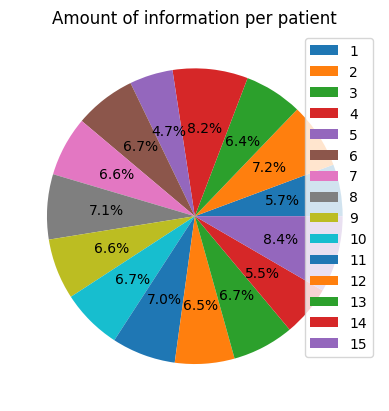

In [7]:
plt.pie(lengths_df["Length"], autopct="%1.1f%%")
plt.title("Amount of information per patient")
plt.legend(lengths_df["Patient"])
plt.show()

# Distribución de etiquetas


In [8]:
labels_dic = {
    1: "Walking",
    3: "Shuffling",
    4: "Stairs (ascending)",
    5: "Stairs (descending)",
    6: "Standing",
    7: "Sitting",
    8: "Lying",
}
data["activity"] = data["label"].map(labels_dic)

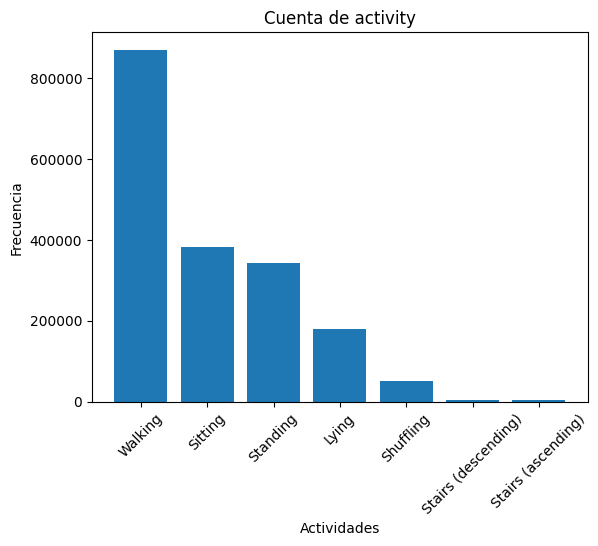

In [9]:
sorted_label_count = data["activity"].value_counts().reset_index()
sorted_label_count.columns = ["Label", "Count"]
plt.bar(sorted_label_count["Label"], sorted_label_count["Count"])
plt.title("Cuenta de activity")
plt.xlabel("Actividades")
plt.ylabel("Frecuencia")
plt.xticks(rotation=45)
plt.show()

In [10]:
x = data.drop(["label", "timestamp", "activity"], axis=1)
y = pd.DataFrame(data["label"])

# Visualización preliminar de datos

En esta sección, se presenta una visualización preliminar de los datos utilizados en nuestro análisis de regresión clasificatoria.

Se han seleccionado de **un paciente** dos variables en principio arbitrarias: la cantidad de movimiento en el **plano X tanto** del **muslo** como de la **espalda**, para explorar gráficamente la relación entre ellas y las etiquetas de clasificación.

Esta representación gráfica nos permitirá observar de manera inicial si existe alguna tendencia o agrupamiento en los datos que pueda influir en nuestro modelo de regresión clasificatoria.


In [12]:
patient = patients_dataframes[0]
patient["activity"] = patient["label"].map(labels_dic)

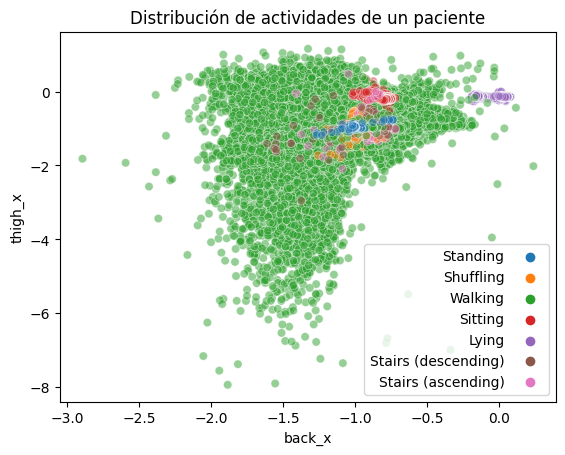

In [ ]:
sns.scatterplot(x="back_x", y="thigh_x", hue="activity", data=patient, alpha=0.5)
plt.legend(loc="lower right", markerfirst=False)
plt.title("Distribución de actividades de un paciente")
plt.show()

Se observa que la actividad de caminar opaca al resto de las variables, dado que su movimiento de distribuye donde se encuentran casi todo el resto de las actividades, y más.

Esto puede ser un indicio de que será necesario submuestrear dicha actividad para hacer una mejor clasificación.

De forma que a este punto es apropiado visualizar de manera más clara el resto de actividades, excluyendo caminar. En este caso **con los datos de todos los pacientes**:


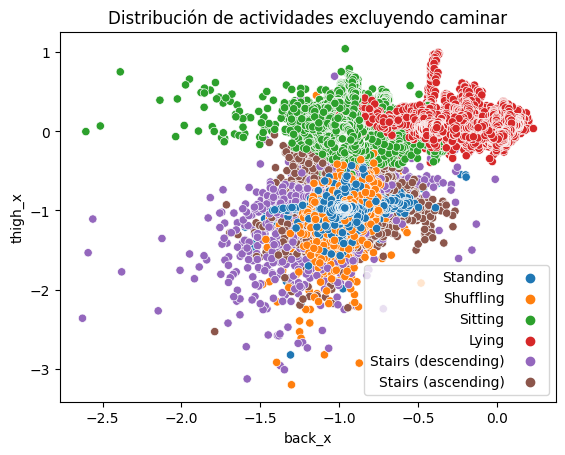

In [ ]:
patients_all_minus_walking = data[data["activity"] != "Walking"]
sns.scatterplot(
    x="back_x", y="thigh_x", hue="activity", data=patients_all_minus_walking
)
plt.legend(loc="lower right", markerfirst=False)
plt.title("Distribución de actividades excluyendo caminar")
plt.show()

Es posible identificar una tendencia para algunas actividades. Es más claro en algunas que en otras, por lo que sí podemos determinar que gran parte de los datos son candidatos para un modelo de clasificación.

Para profundizar, compararemos todas las variables entre sí, tomando cada variable como una posible $x$ y $y$ en un plano cartesiano, así podemos ver patrones que surjan de diferentes combinaciones de dos variables.


In [13]:
patient_minus_walking = patient.drop("label", axis=1)
patient_minus_walking = patient_minus_walking[
    patient_minus_walking["activity"] != "Walking"
]

c:\Users\musel\anaconda3\envs\cuda\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


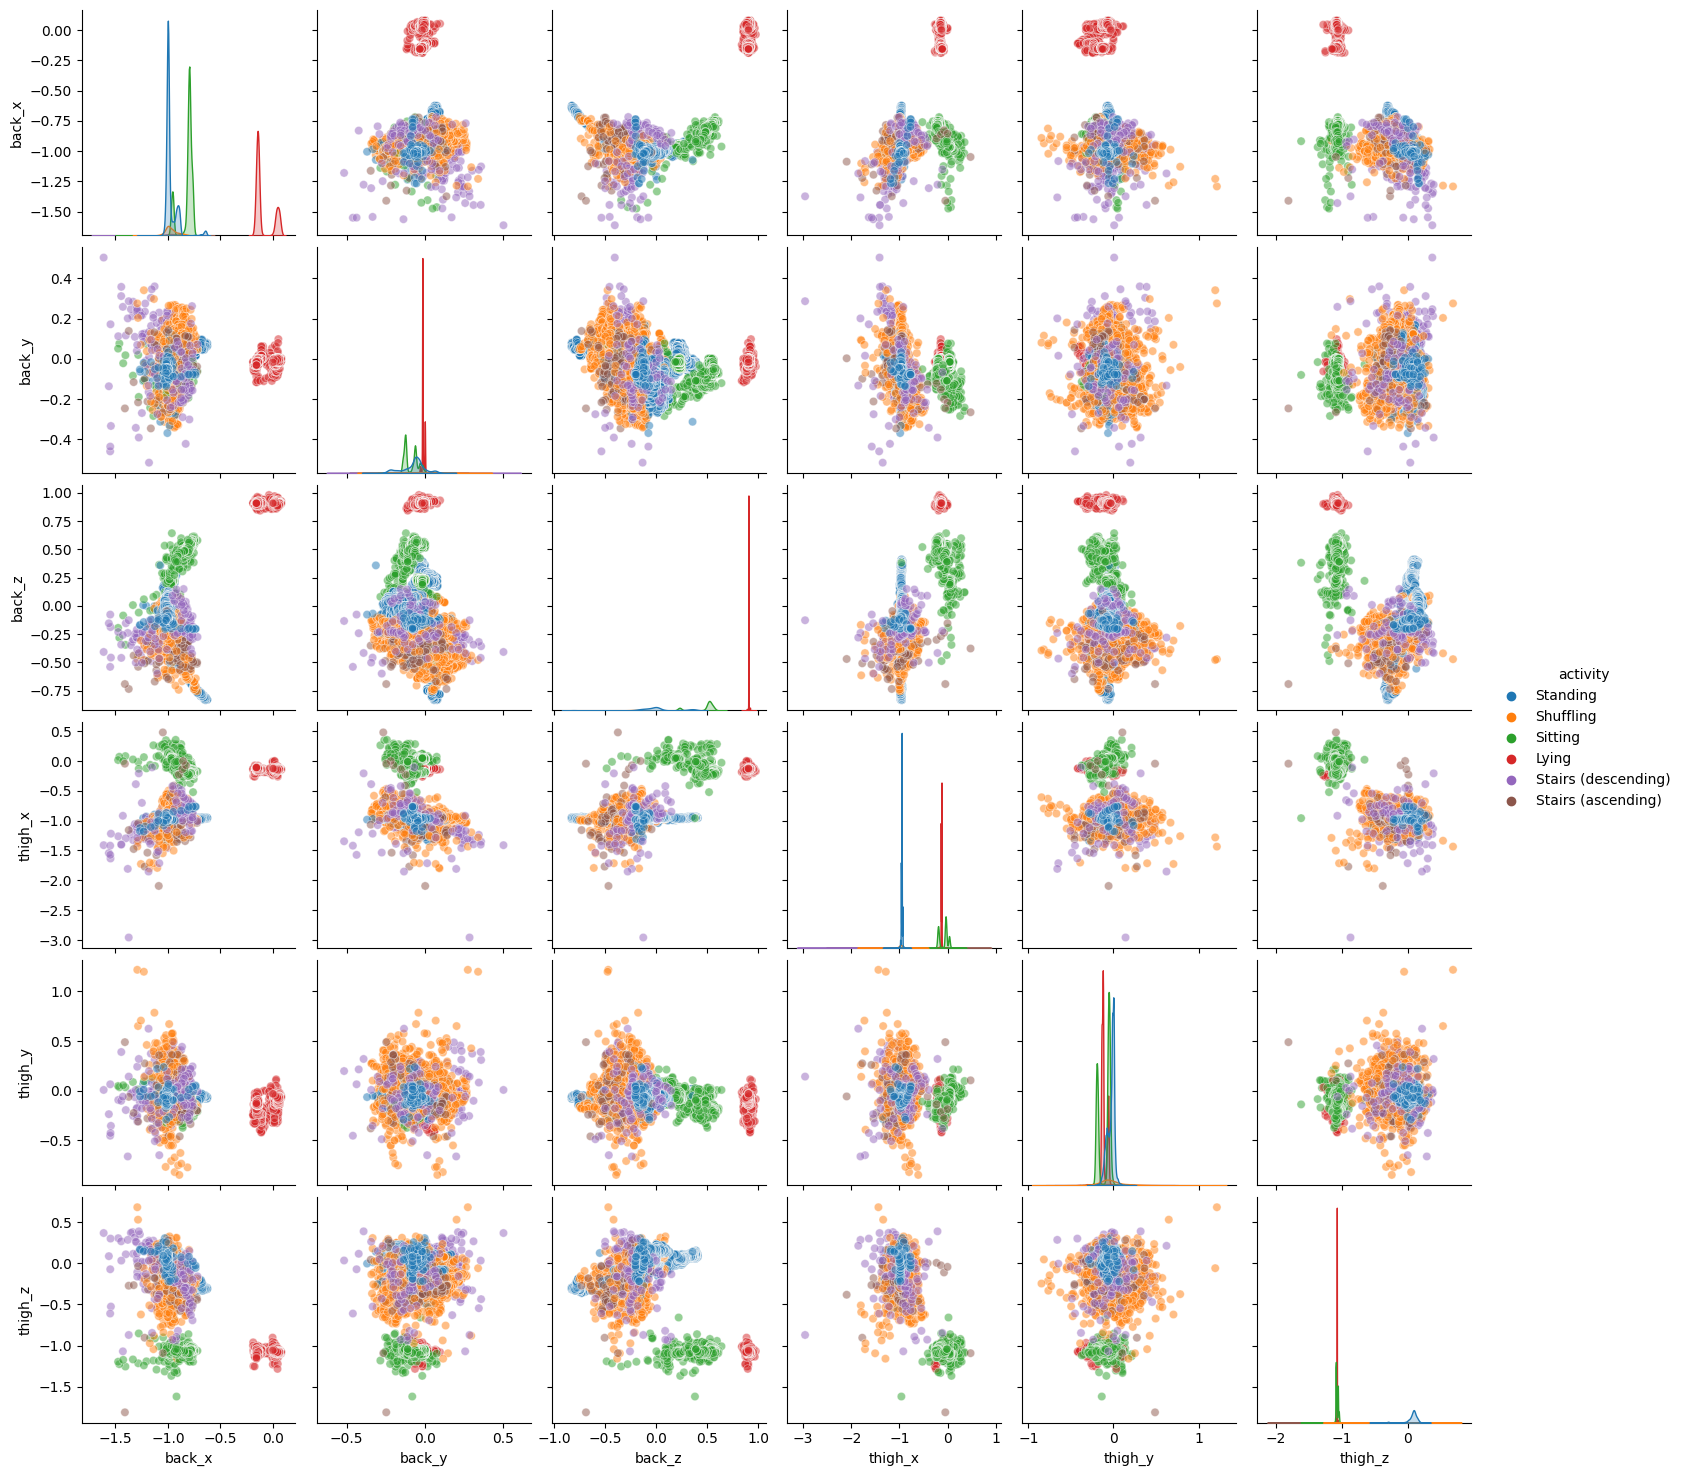

In [ ]:
sns.pairplot(
    patient_minus_walking.iloc[:, 1:8], hue="activity", plot_kws={"alpha": 0.5}
)

Nuevamente se reafirma que hay actividades con distribuciones más peculiares que en otras, como permaneceser sentado y sobre todo permanecer quieto.

Para el resto de actividades es más difuso establecer su distrbución en el plano a simple vista, e incluso para cierta combinación de variables se vuelven mucho más difusas las dos actividades ya mencionadas anteriormente, cuando en otros casos se observan de manera clara.


## Histogramas


In [15]:
data = data.drop(["timestamp", "activity"], axis=1)

Text(0.5, 1.0, 'Values frequency per variable')

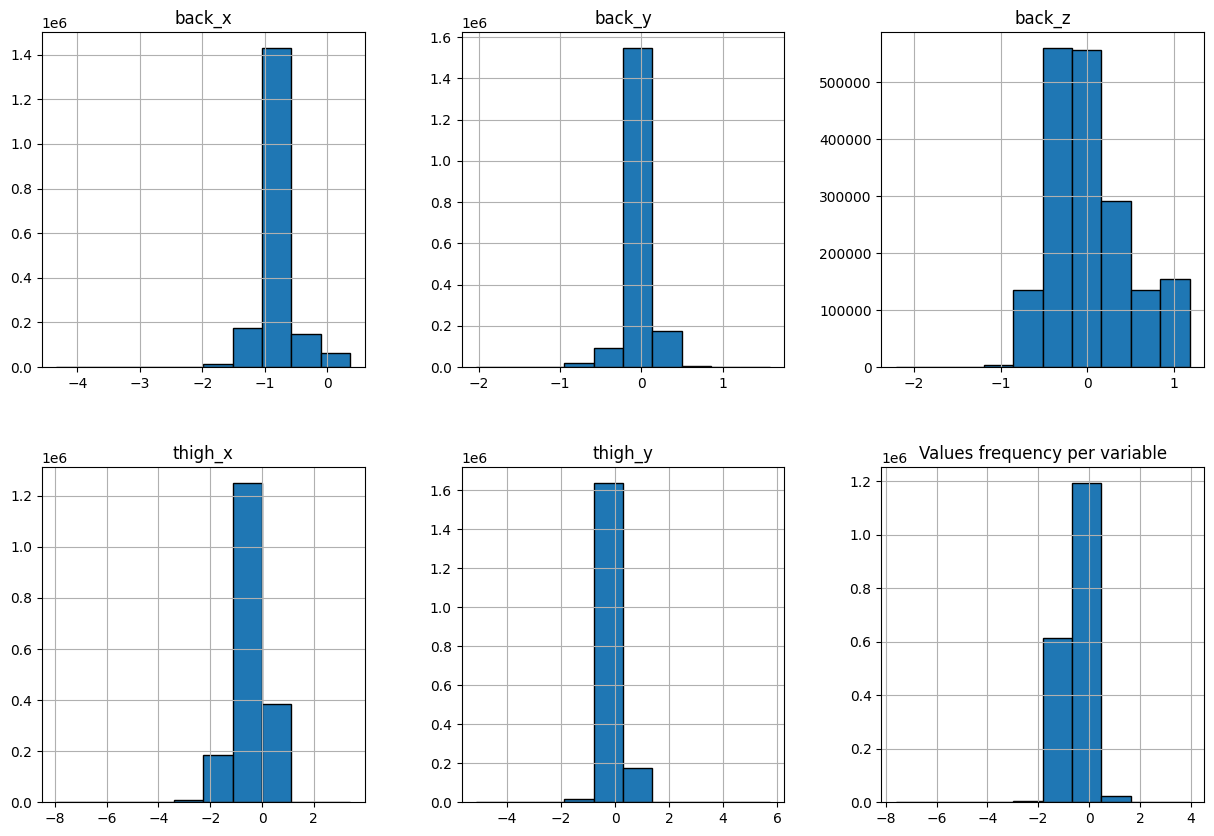

In [ ]:
x.hist(figsize=(15, 10), layout=(2, 3), edgecolor="black")
plt.title("Values frequency per variable")

## Distribucion de cada variable por actividad


## Medidas estadisticas de las variables


In [ ]:
x.describe()

,back_x,back_y,back_z,thigh_x,thigh_y,thigh_z
count,1.832560e+06,1.832560e+06,1.832560e+06,1.832560e+06,1.832560e+06,1.832560e+06
mean,-8.683814e-01,-3.178814e-02,2.244210e-02,-6.763959e-01,8.185066e-03,-3.858819e-01
std,2.756643e-01,1.556768e-01,4.279549e-01,5.596829e-01,2.707317e-01,5.087015e-01
min,-4.333252e+00,-2.031006e+00,-2.204834e+00,-7.942139e+00,-5.142578e+00,-7.593750e+00
25%,-9.909670e-01,-1.093750e-01,-2.692870e-01,-9.855960e-01,-1.132810e-01,-9.770510e-01
50%,-9.377440e-01,-1.855500e-02,-9.399400e-02,-9.357910e-01,-1.464800e-02,-1.906740e-01
75%,-8.344730e-01,5.761700e-02,3.078610e-01,-7.763700e-02,1.230470e-01,-3.174000e-03
max,3.630370e-01,1.576660e+00,1.179199e+00,3.395264e+00,5.725098e+00,3.953369e+00


## Medidas estadisticas por actividad


In [ ]:
data.groupby(["label"]).mean()

,back_x,back_y,back_z,thigh_x,thigh_y,thigh_z
label,,,,,,
1,-0.963939,-0.031038,-0.214323,-0.993390,-0.030237,-0.148173
3,-0.968706,-0.014800,-0.178747,-0.969429,-0.021790,-0.120222
4,-0.919728,-0.013897,-0.335612,-0.877378,0.017482,-0.411016
5,-0.960695,-0.024264,-0.237272,-0.920575,0.004020,-0.352167
6,-0.969500,-0.026409,-0.132345,-0.968025,-0.024078,-0.033499
7,-0.860949,-0.024844,0.339883,0.013083,0.086276,-1.022991
8,-0.193262,-0.065995,0.864865,0.047007,0.098721,-0.934210


In [ ]:
data.groupby(["label"]).std()

,back_x,back_y,back_z,thigh_x,thigh_y,thigh_z
label,,,,,,
1,0.187814,0.150982,0.251046,0.439190,0.319099,0.400945
3,0.056216,0.112661,0.198847,0.096010,0.176863,0.197181
4,0.162513,0.121404,0.195362,0.293213,0.217901,0.322530
5,0.188784,0.156753,0.174102,0.285253,0.244615,0.311463
6,0.043508,0.085381,0.233046,0.028036,0.107960,0.155767
7,0.143036,0.112215,0.287691,0.135054,0.169800,0.066368
8,0.186082,0.301151,0.132391,0.091385,0.360533,0.313189


## Correlacion entre variables


<Axes: >

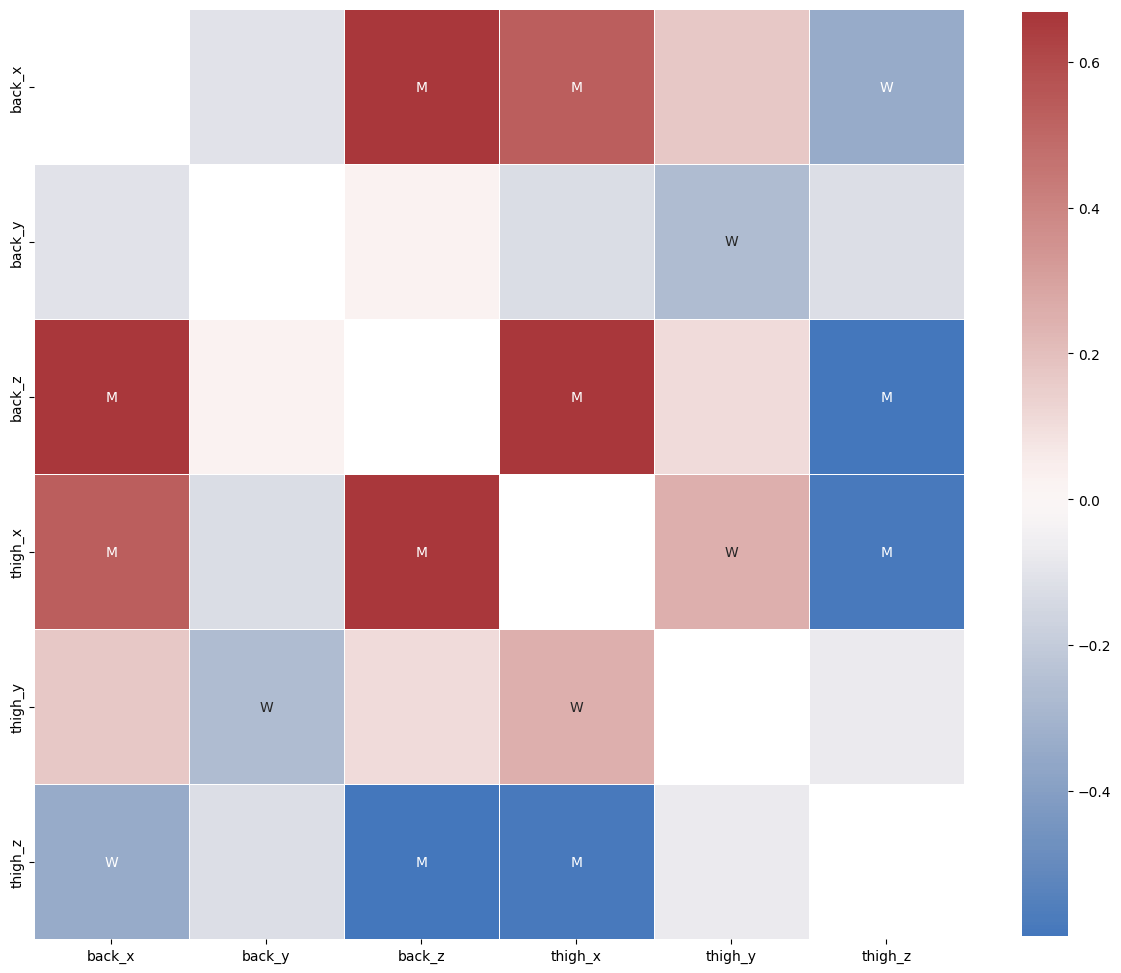

In [24]:
df_corr = x.corr(method="pearson")

labels = np.where(
    np.abs(df_corr) > 0.75,
    "S",
    np.where(np.abs(df_corr) > 0.5, "M", np.where(np.abs(df_corr) > 0.25, "W", "")),
)

plt.figure(figsize=(15, 15))
sns.heatmap(
    df_corr,
    mask=np.eye(len(df_corr)),
    square=True,
    center=0,
    annot=labels,
    fmt="",
    linewidths=0.5,
    cmap="vlag",
    cbar_kws={"shrink": 0.8},
)

In [25]:
# ordenar correlaciones
lower_triangle_mask = np.tril(np.ones(df_corr.shape), k=-1).astype("bool")
df_corr_stacked = df_corr.where(lower_triangle_mask).stack().sort_values()
display(df_corr_stacked)

thigh_z  back_z    -0.599072
         thigh_x   -0.585705
         back_x    -0.342677
thigh_y  back_y    -0.266343
thigh_x  back_y    -0.125428
thigh_z  back_y    -0.122763
back_y   back_x    -0.104797
thigh_z  thigh_y   -0.076374
back_z   back_y     0.025312
thigh_y  back_z     0.106654
         back_x     0.171067
         thigh_x    0.251240
thigh_x  back_x     0.533433
back_z   back_x     0.667065
thigh_x  back_z     0.667972
dtype: float64

# Entrenamiento


In [26]:
# balancear datos dejando el numero de datos igual a la categoria con menor cantidad de datos
data_balanced = data.groupby("label").sample(
    n=data["label"].value_counts().min(), random_state=42
)

# agrupamos para mostrar la cantidad de datos por categoria
contar = data_balanced.groupby(by="label").count()
contar.head(10)

,back_x,back_y,back_z,thigh_x,thigh_y,thigh_z
label,,,,,,
1,3726,3726,3726,3726,3726,3726
3,3726,3726,3726,3726,3726,3726
4,3726,3726,3726,3726,3726,3726
5,3726,3726,3726,3726,3726,3726
6,3726,3726,3726,3726,3726,3726
7,3726,3726,3726,3726,3726,3726
8,3726,3726,3726,3726,3726,3726


In [28]:
# necessary models
from sklearn.tree import ExtraTreeClassifier, DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import (
    SGDClassifier,
    RidgeClassifier,
    PassiveAggressiveClassifier,
    LogisticRegression,
    Perceptron,
)
from sklearn.ensemble import (
    AdaBoostClassifier,
    BaggingClassifier,
    ExtraTreesClassifier,
    RandomForestClassifier,
)
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import (
    QuadraticDiscriminantAnalysis,
    LinearDiscriminantAnalysis,
)
from sklearn.neighbors import NearestCentroid, KNeighborsClassifier

# for evaluate
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

# for cross validation
from sklearn.model_selection import KFold

In [29]:
names = [
    "Random Forest Classifier",
    "KNeighborsClassifier",
    "SGDClassifier",
    "PassiveAggressiveClassifier",
    "BaggingClassifier",
    "ExtraTreesClassifier",
    "LogisticRegression",
    "Perceptron",
    "QuadraticDiscriminantAnalysis",
    "ExtraTreeClassifier",
    "DecisionTreeClassifier",
    "MLPClassifier",
    "RidgeClassifier",
    "AdaBoostClassifier",
    "GaussianNB",
    "LinearDiscriminantAnalysis",
    "NearestCentroid",
]

In [30]:
classifiers = [
    RandomForestClassifier(n_jobs=-1),
    KNeighborsClassifier(n_jobs=-1),
    SGDClassifier(n_jobs=-1),
    PassiveAggressiveClassifier(n_jobs=-1),
    BaggingClassifier(n_jobs=-1),
    ExtraTreesClassifier(n_jobs=-1),
    LogisticRegression(n_jobs=-1),
    Perceptron(n_jobs=-1),
    QuadraticDiscriminantAnalysis(),
    ExtraTreeClassifier(),
    DecisionTreeClassifier(),
    MLPClassifier(),
    RidgeClassifier(),
    AdaBoostClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    NearestCentroid(),
]

In [31]:
datasets = (data_balanced.iloc[:, :-1].values, data_balanced.iloc[:, -1].values)

avg_score = dict(map(lambda x: [x, 0], names))
avg_recall = dict(map(lambda x: [x, 0], names))
avg_f1 = dict(map(lambda x: [x, 0], names))
avg_precision = dict(map(lambda x: [x, 0], names))

matrices = dict(map(lambda x: [x, np.zeros([7, 7])], names))

X, y = datasets

In [32]:
n_folds = 5
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42).split(X)
for indice, (train_index, test_index) in enumerate(kf):
    X_train = X[train_index, :]
    y_train = y[train_index]
    X_test = X[test_index, :]
    y_test = y[test_index]
    for name, clf in zip(names, classifiers):
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        avg_score[name] += accuracy_score(y_test, y_pred)
        avg_recall[name] += recall_score(
            y_test, y_pred, average="micro", zero_division=0
        )
        avg_f1[name] += f1_score(y_test, y_pred, average="micro", zero_division=0)
        avg_precision[name] += precision_score(
            y_test, y_pred, average="micro", zero_division=0
        )

        matrices[name] += confusion_matrix(y_test, y_pred, labels=clf.classes_)

c:\Users\cm_cj\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cm_cj\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cm_cj\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cm_cj\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

In [34]:
print(f"\nThe average accuracy is:")
for keys, value in avg_score.items():
    value /= n_folds
    print(f"{keys}: {value}")

print(f"\nThe average recall per label is:")
for keys, value in avg_recall.items():
    value /= n_folds
    print(f"{keys}: {value}")

print(f"\nThe average f1 per label is:")
for keys, value in avg_f1.items():
    value /= n_folds
    print(f"{keys}: {value}")

print(f"\nThe average precision per label is:")
for keys, value in avg_precision.items():
    value /= n_folds
    print(f"{keys}: {value}")


The average accuracy is:
Random Forest Classifier: 0.7721417989912639
KNeighborsClassifier: 0.7580323250087314
SGDClassifier: 0.4881941749542259
PassiveAggressiveClassifier: 0.4528043495133301
BaggingClassifier: 0.7407027418032834
ExtraTreesClassifier: 0.7826471695883326
LogisticRegression: 0.5505325249214754
Perceptron: 0.4151918250975163
QuadraticDiscriminantAnalysis: 0.6210795567464082
ExtraTreeClassifier: 0.6475350538176866
DecisionTreeClassifier: 0.6843414521426531
MLPClassifier: 0.6979525480643155
RidgeClassifier: 0.49444002235494866
AdaBoostClassifier: 0.4035330608640228
GaussianNB: 0.5922475234338894
LinearDiscriminantAnalysis: 0.5337776100078672
NearestCentroid: 0.5334322754421306

The average recall per label is:
Random Forest Classifier: 0.7721417989912639
KNeighborsClassifier: 0.7580323250087314
SGDClassifier: 0.4881941749542259
PassiveAggressiveClassifier: 0.4528043495133301
BaggingClassifier: 0.7407027418032834
ExtraTreesClassifier: 0.7826471695883326
LogisticRegression:

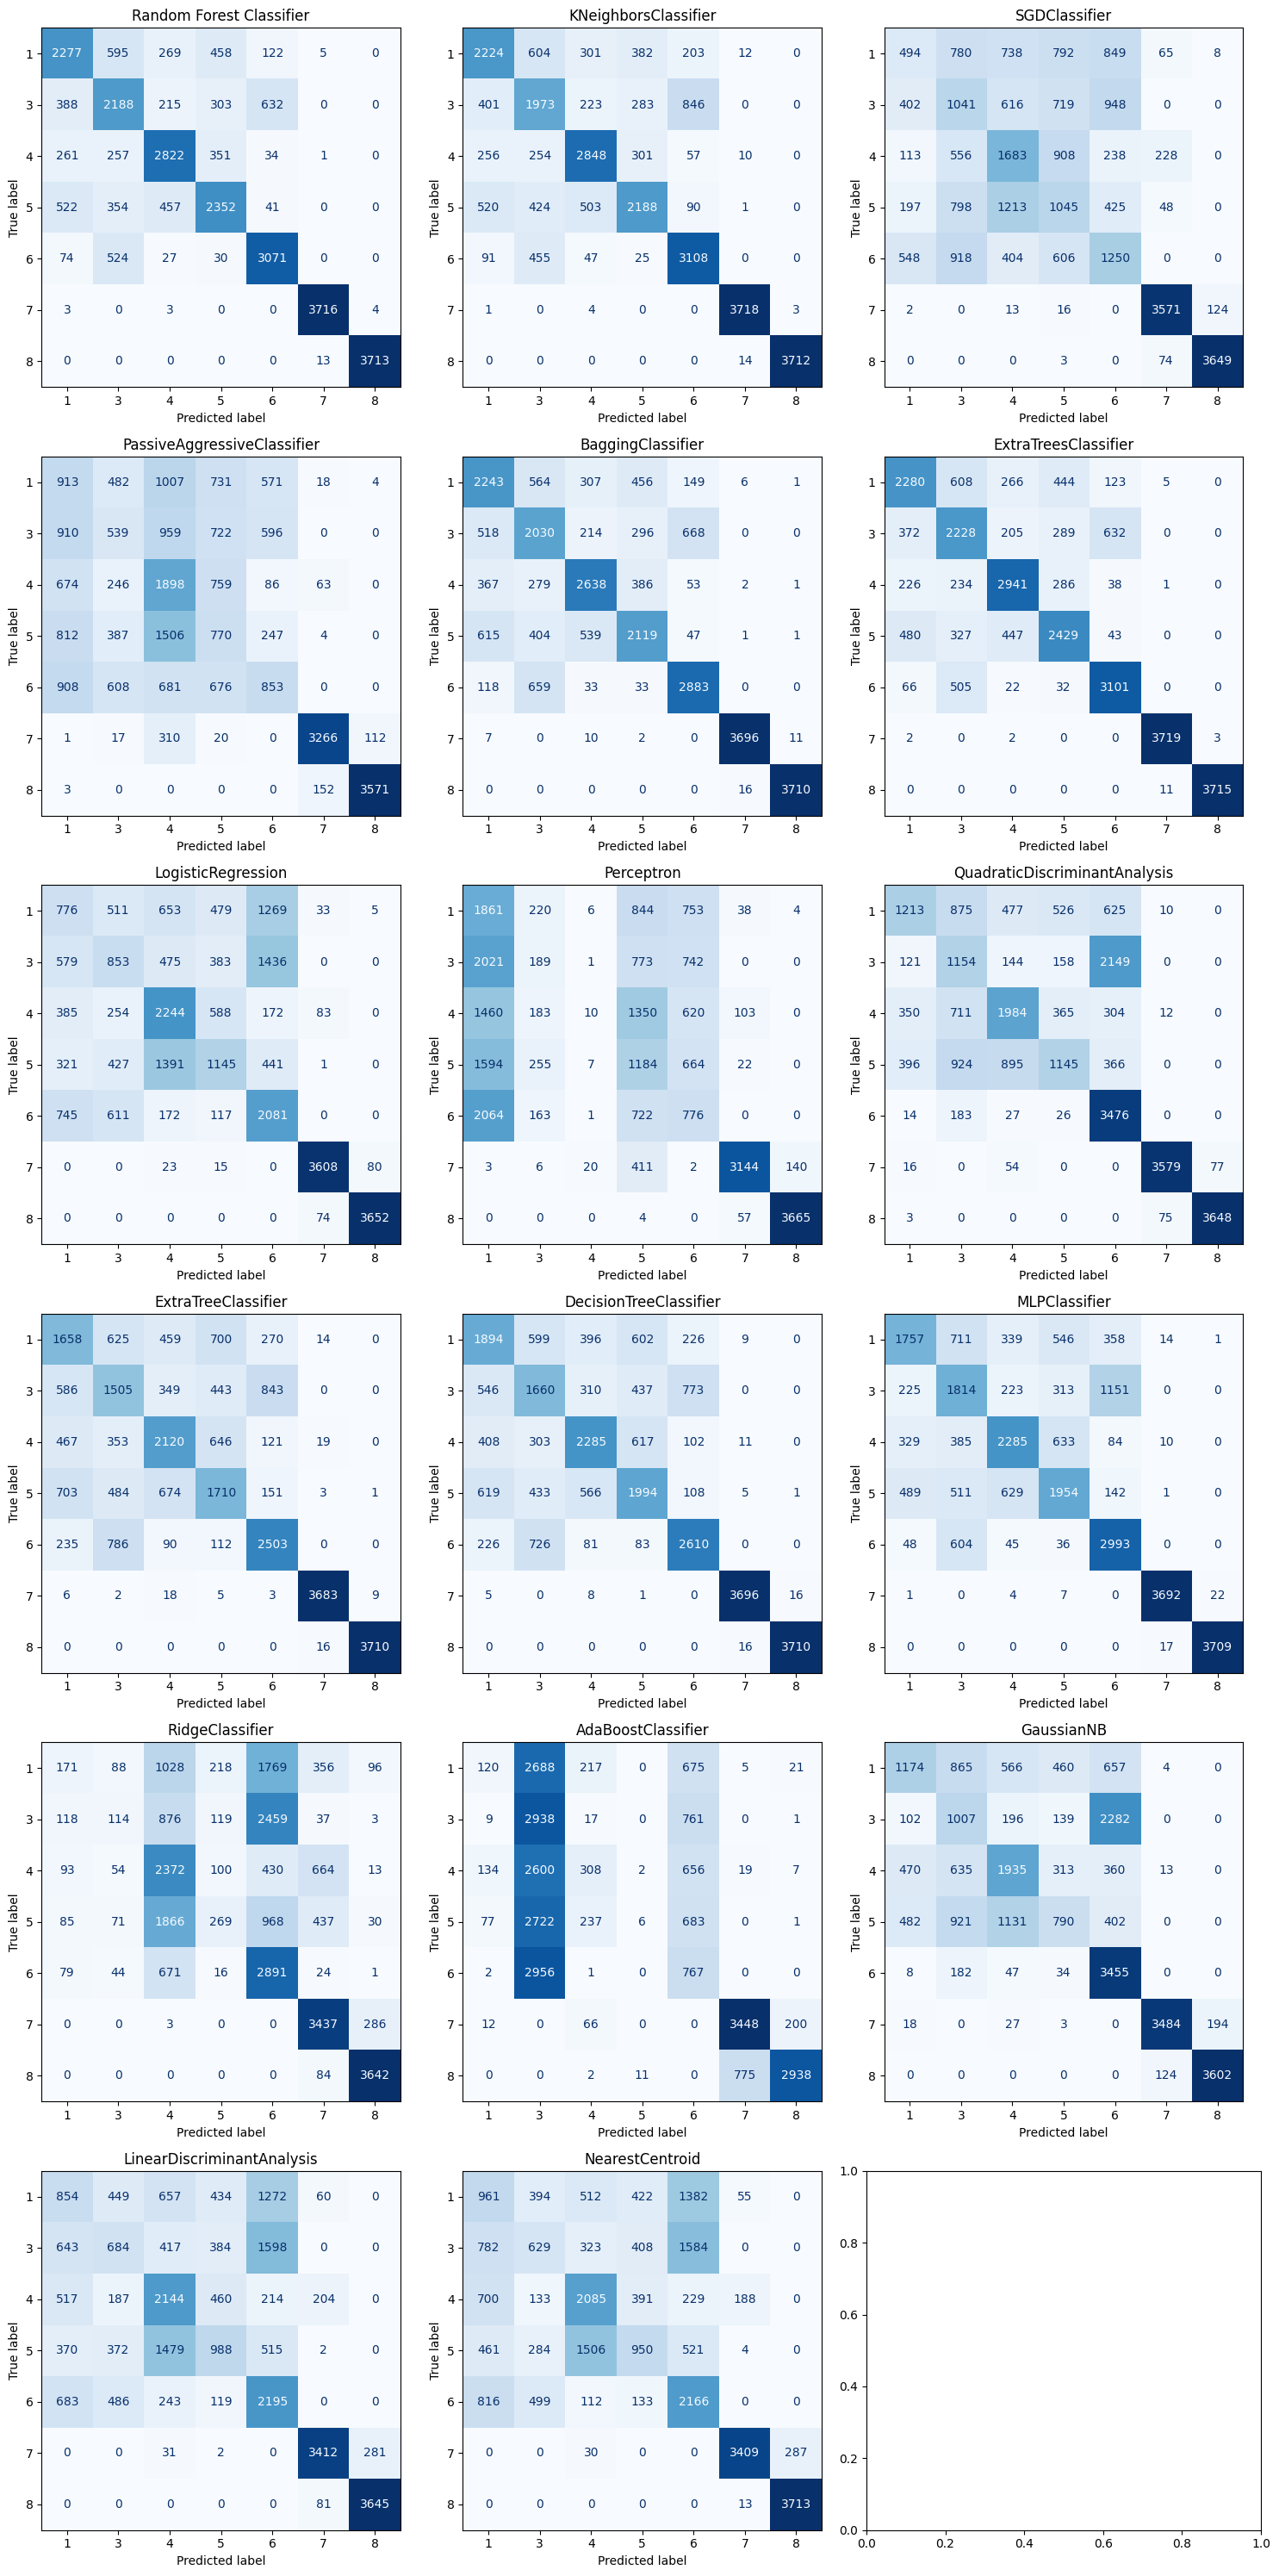

In [35]:
fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(15, 30))
for (keys, value), ax in zip(matrices.items(), axes.flatten()):
    value = value.astype(int)
    ConfusionMatrixDisplay(
        confusion_matrix=value, display_labels=[1, 3, 4, 5, 6, 7, 8]
    ).plot(ax=ax, colorbar=False, cmap="Blues")
    ax.title.set_text(keys)
    fig.set_tight_layout(True)

Se eligieron RandomForestClassifier, Kneighbors, ExtraTreesClassifier, BaggingClassifier y MLPClassifier, por ser los que presentan las 5 mejores métricas de evaluación (accuracy, recall, precision y f1).
